### 1. Client erstellen

In [1]:
import os
from dotenv import load_dotenv
from edge_benchmarking_client.client import EdgeBenchmarkingClient

In [2]:
load_dotenv()

# Connection information
EDGE_FARM_API_PROTOCOL = os.getenv("EDGE_FARM_API_PROTOCOL")
EDGE_FARM_API_HOST = os.getenv("EDGE_FARM_API_HOST")

# Basic API authentication
EDGE_FARM_API_BASIC_AUTH_USERNAME = os.getenv("EDGE_FARM_API_BASIC_AUTH_USERNAME")
EDGE_FARM_API_BASIC_AUTH_PASSWORD = os.getenv("EDGE_FARM_API_BASIC_AUTH_PASSWORD")

# Create the client
client = EdgeBenchmarkingClient(
    protocol=EDGE_FARM_API_PROTOCOL,
    host=EDGE_FARM_API_HOST,
    username=EDGE_FARM_API_BASIC_AUTH_USERNAME,
    password=EDGE_FARM_API_BASIC_AUTH_PASSWORD,
)

2024-11-29 14:47:34.287 INFO client - __init__: Created Edge Benchmarking client for user 'admin' and Edge Farm at 'https://api.edge-farm.agrifood-tef.edvsz.hs-osnabrueck.de'.
2024-11-29 14:47:34.333 INFO client - get_welcome_message: 200 - {'message': "Welcome to the REST API of AgrifoodTEF's Edge Benchmarking Service!"}
2024-11-29 14:47:34.334 INFO client - _test_connection: Edge Farm API at 'https://api.edge-farm.agrifood-tef.edvsz.hs-osnabrueck.de' is reachable with status code 200.


### 2. Benchmark-Daten finden und einlesen

In [3]:
!rm -rf densenet_onnx/dataset/.ipynb_checkpoints
!rm -rf densenet_onnx/model/.ipynb_checkpoints

In [4]:
EXAMPLE_ROOT_DIR = "densenet_onnx"
DATASET_DIR = f"{EXAMPLE_ROOT_DIR}/dataset"
MODEL_DIR= f"{EXAMPLE_ROOT_DIR}/model"

dataset = client.find_dataset(
    root_dir=DATASET_DIR, file_extensions={".jpg", ".jpeg", ".JPG", ".JPEG", ".png", ".PNG"}
)
model = client.find_model(root_dir=MODEL_DIR)
model_metadata = client.find_model_metadata(root_dir=MODEL_DIR)
labels = client.find_labels(root_dir=MODEL_DIR)

2024-11-29 14:47:36.017 INFO client - find_dataset: Found dataset containing 50 samples with type(s) {'.jpg', '.jpeg', '.PNG', '.png', '.JPEG', '.JPG'} in '/home/jovyan/work/edge-benchmarking-client/examples/densenet_onnx/dataset'.
2024-11-29 14:47:36.021 INFO client - _find_file: Found file '/home/jovyan/work/edge-benchmarking-client/examples/densenet_onnx/model/densenet_onnx.onnx' with extension {'.pth', '.pt', '.onnx'} in '/home/jovyan/work/edge-benchmarking-client/examples/densenet_onnx/model'.
2024-11-29 14:47:36.023 INFO client - _find_file: Found file '/home/jovyan/work/edge-benchmarking-client/examples/densenet_onnx/model/config.pbtxt' with extension {'.pbtxt'} in '/home/jovyan/work/edge-benchmarking-client/examples/densenet_onnx/model'.
2024-11-29 14:47:36.026 INFO client - _find_file: Found file '/home/jovyan/work/edge-benchmarking-client/examples/densenet_onnx/model/densenet_labels.txt' with extension {'.txt'} in '/home/jovyan/work/edge-benchmarking-client/examples/densenet_

### 3. Benchmark-Job starten und auf Ergebnisse warten

In [5]:
from edge_benchmarking_types.edge_farm.models import TritonInferenceClientConfig

EDGE_DEVICE_HOST="edge-03"

inference_client_config = TritonInferenceClientConfig(
    host=EDGE_DEVICE_HOST,
    model_name=EXAMPLE_ROOT_DIR,
    num_classes=10,
    scaling="inception",
)

benchmark_job = client.benchmark(
    edge_device=EDGE_DEVICE_HOST,
    dataset=dataset,
    model=model,
    model_metadata=model_metadata,
    labels=labels,
    inference_client_config=inference_client_config,
)

2024-11-29 14:47:36.944 INFO client - upload_benchmark_data: 200 - bucket_name='5cfad1db-dc9d-429e-8672-5fceaa94802a' dataset=['dataset/ILSVRC2012_test_00011512.JPEG', 'dataset/ILSVRC2012_test_00011532.JPEG', 'dataset/ILSVRC2012_test_00011492.JPEG', 'dataset/ILSVRC2012_test_00011491.JPEG', 'dataset/ILSVRC2012_test_00011527.JPEG', 'dataset/ILSVRC2012_test_00011531.JPEG', 'dataset/ILSVRC2012_test_00011503.JPEG', 'dataset/ILSVRC2012_test_00011506.JPEG', 'dataset/ILSVRC2012_test_00011509.JPEG', 'dataset/ILSVRC2012_test_00011511.JPEG', 'dataset/ILSVRC2012_test_00011529.JPEG', 'dataset/ILSVRC2012_test_00011508.JPEG', 'dataset/ILSVRC2012_test_00011533.JPEG', 'dataset/ILSVRC2012_test_00011501.JPEG', 'dataset/ILSVRC2012_test_00011526.JPEG', 'dataset/ILSVRC2012_test_00011495.JPEG', 'dataset/ILSVRC2012_test_00011510.JPEG', 'dataset/ILSVRC2012_test_00011485.JPEG', 'dataset/ILSVRC2012_test_00011515.JPEG', 'dataset/ILSVRC2012_test_00011507.JPEG', 'dataset/ILSVRC2012_test_00011530.JPEG', 'dataset/ILS

### 4. Ergebnisse abrufen

In [6]:
import torch
import numpy as np
import pandas as pd
import torch.nn.functional as F

from collections import defaultdict

2024-11-29 14:47:57.326 INFO utils - _init_num_threads: NumExpr defaulting to 8 threads.


In [7]:
benchmark_results = pd.DataFrame(benchmark_job.benchmark_results)
benchmark_results["time"] = pd.to_datetime(benchmark_results["time"])
benchmark_results.set_index("time", inplace=True)
print(benchmark_results)

                                   uptime  CPU1  CPU2  CPU3  CPU4  CPU5  CPU6  \
time                                                                            
2024-11-29 15:47:41.084269   P3DT3H54.09S    10     2    18     1     2     2   
2024-11-29 15:47:41.084843   P3DT3H54.09S    10     2    18     1     2     2   
2024-11-29 15:47:41.365104   P3DT3H55.09S     4     0     0     1     1     0   
2024-11-29 15:47:42.431013   P3DT3H56.09S     2     3     2     1     0     1   
2024-11-29 15:47:43.354400   P3DT3H57.09S     4    52     0     0     4     2   
2024-11-29 15:47:44.364208   P3DT3H58.09S     2    17    70     0    11     5   
2024-11-29 15:47:45.348178   P3DT3H59.09S     2     1    80     0     5     2   
2024-11-29 15:47:46.358112  P3DT3H1M0.09S     0     0    90     0    20     1   
2024-11-29 15:47:47.360909  P3DT3H1M1.09S     1     0    89     0     5    20   
2024-11-29 15:47:48.359354  P3DT3H1M2.09S     2    12    89     1     3     5   
2024-11-29 15:47:49.355438  

In [8]:
final_inference_results = defaultdict(list)
for inference_respone_id, inference_result in benchmark_job.inference_results.items():
    predictions = np.stack(inference_result)

    logits = predictions[:, 0].astype(float)
    probabilities = F.softmax(torch.tensor(logits), dim=0)

    predicted_classes = predictions[:, -1]
    predicted_class_index = probabilities.argmax()
    predicted_probability = probabilities.max()
    predicted_class = predicted_classes[predicted_class_index]

    final_inference_results["response id"].append(inference_respone_id)
    final_inference_results["class"].append(predicted_class)
    final_inference_results["probability"].append(
        predicted_probability.item() * 100
    )

    inference_results_df = pd.DataFrame(final_inference_results)
print(inference_results_df)

   response id                 class  probability
0            0          HORNED VIPER    39.709751
1            1                  MAZE    62.952496
2            2               MONARCH    94.261846
3            3             ARMADILLO    99.903198
4            4             STREETCAR    88.823460
5            5                 VAULT    67.610083
6            6           WATER OUZEL    40.576032
7            7            STONE WALL    99.526328
8            8                MARACA    56.989351
9            9               MACAQUE    51.929487
10          10               WARTHOG    59.995851
11          11            COFFEE MUG    59.707184
12          12                  TICK    31.170016
13          13               LADYBUG    63.750313
14          14               ROOSTER    77.620369
15          15  RECREATIONAL VEHICLE    89.658168
16          16            MICROPHONE    63.267688
17          17               MODEL T    99.880440
18          18             TURNSTILE    48.271606


### 5. Ergebnisse visualisieren

In [9]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

Text(0, 0.5, 'Utilization [%]')

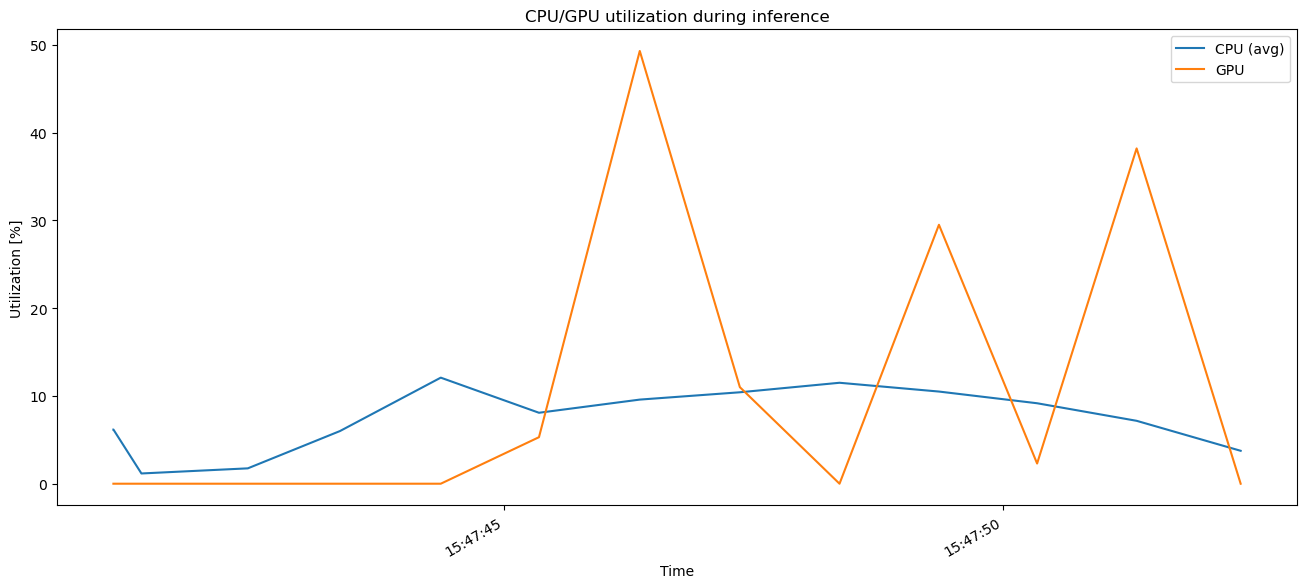

In [10]:
benchmark_results['CPU (avg)'] = benchmark_results[[f'CPU{i+1}' for i in range(12)]].mean(axis=1)

ax = benchmark_results.plot(y=["CPU (avg)", "GPU"], figsize=(16, 7))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

plt.title('CPU/GPU utilization during inference')
plt.xlabel('Time')
plt.ylabel('Utilization [%]')